<a href="https://colab.research.google.com/github/Andreavisi1/Challenge_B1_PHM_North_America_2023/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


ModuleNotFoundError: No module named 'google'

In [ ]:
!cp "/content/drive/MyDrive/ProgettoManutenzionePreventiva/Data_Challenge_PHM2023_test_data.zip" "/tmp/"

!unzip -oq "/tmp/Data_Challenge_PHM2023_test_data.zip" -d "/tmp"

!cp "/content/drive/MyDrive/ProgettoManutenzionePreventiva/Data_Challenge_PHM2023_training_data.zip" "/tmp/"

!unzip -oq "/tmp/Data_Challenge_PHM2023_training_data.zip" -d "/tmp"

In [1]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
ROOT_VAL_DATA_FOLDER = 'B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_test_data'

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

## Data Extraction

In [ ]:
def parse_vibration_dataset(dataset_path, compute_stats=True):
    """
    Parsa il dataset di vibrazione e crea un DataFrame con statistiche aggregate per file.
    
    Args:
        dataset_path (str): Percorso alla cartella principale del dataset
        compute_stats (bool): Se True, calcola statistiche invece di caricare tutti i dati
    
    Returns:
        pd.DataFrame: DataFrame con statistiche per ogni file
    """
    
    data_list = []
    
    # Conta prima i file per la progress bar
    total_files = sum(1 for root, dirs, files in os.walk(dataset_path) 
                     for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file da processare...")
    
    with tqdm(total=total_files, desc="Processing files") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    pbar.update(1)
                    
                    # Estrai informazioni dalla cartella
                    folder_name = os.path.basename(root)
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta = folder_name.replace('Pitting_degradation_level_', '').strip()
                        # Gestisci eventuali descrizioni tra parentesi
                        if '(' in etichetta:
                            etichetta = etichetta.split('(')[0].strip()
                    else:
                        etichetta = folder_name
                    
                    # Estrai informazioni dal nome del file
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)
                    
                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))
                        
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Carica i dati
                            data = np.loadtxt(file_path)
                            
                            if compute_stats:
                                # Calcola statistiche invece di salvare tutti i dati
                                record = {
                                    'etichetta': etichetta,
                                    'velocita': velocita,
                                    'torque': torque,
                                    'rep': rep,
                                    'file_path': file_path,
                                    'num_samples': len(data),
                                    # Statistiche accelerazione orizzontale
                                    'h_acc_mean': np.mean(data[:, 0]),
                                    'h_acc_std': np.std(data[:, 0]),
                                    'h_acc_rms': np.sqrt(np.mean(data[:, 0] ** 2)),
                                    'h_acc_max': np.max(np.abs(data[:, 0])),
                                    'h_acc_kurtosis': np.mean((data[:, 0] - np.mean(data[:, 0]))**4) / np.std(data[:, 0])**4 - 3,
                                    'h_acc_skewness': np.mean((data[:, 0] - np.mean(data[:, 0]))**3) / np.std(data[:, 0])**3,
                                    # Statistiche accelerazione assiale
                                    'a_acc_mean': np.mean(data[:, 1]),
                                    'a_acc_std': np.std(data[:, 1]),
                                    'a_acc_rms': np.sqrt(np.mean(data[:, 1] ** 2)),
                                    'a_acc_max': np.max(np.abs(data[:, 1])),
                                    'a_acc_kurtosis': np.mean((data[:, 1] - np.mean(data[:, 1]))**4) / np.std(data[:, 1])**4 - 3,
                                    'a_acc_skewness': np.mean((data[:, 1] - np.mean(data[:, 1]))**3) / np.std(data[:, 1])**3,
                                    # Statistiche accelerazione verticale
                                    'v_acc_mean': np.mean(data[:, 2]),
                                    'v_acc_std': np.std(data[:, 2]),
                                    'v_acc_rms': np.sqrt(np.mean(data[:, 2] ** 2)),
                                    'v_acc_max': np.max(np.abs(data[:, 2])),
                                    'v_acc_kurtosis': np.mean((data[:, 2] - np.mean(data[:, 2]))**4) / np.std(data[:, 2])**4 - 3,
                                    'v_acc_skewness': np.mean((data[:, 2] - np.mean(data[:, 2]))**3) / np.std(data[:, 2])**3,
                                    # Tachometer info
                                    'tach_mean': np.mean(data[:, 3]) if data.shape[1] > 3 else 0,
                                    'tach_std': np.std(data[:, 3]) if data.shape[1] > 3 else 0
                                }
                                data_list.append(record)
                            else:
                                # Salva solo metadati base
                                record = {
                                    'etichetta': etichetta,
                                    'velocita': velocita,
                                    'torque': torque,
                                    'rep': rep,
                                    'file_path': file_path,
                                    'num_samples': len(data),
                                    'data': data  # Attenzione: usa solo per pochi file!
                                }
                                data_list.append(record)
                                
                        except Exception as e:
                            print(f"\nErrore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        print(f"\nNome file non riconosciuto: {file}")
    
    df = pd.DataFrame(data_list)
    
    if not df.empty:
        # Converti etichetta in intero se possibile
        try:
            df['etichetta'] = df['etichetta'].astype(int)
        except:
            print("Etichette non convertibili in interi")
            
        df = df.sort_values(['etichetta', 'velocita', 'torque', 'rep']).reset_index(drop=True)
    
    return df

def extract_frequency_features(data, fs=20480, n_features=20):
    """
    Estrae features nel dominio della frequenza.
    
    Args:
        data: array di dati temporali
        fs: frequenza di campionamento
        n_features: numero di features da estrarre
    
    Returns:
        dict: dizionario con le features estratte
    """
    # FFT
    fft = np.fft.rfft(data)
    freq = np.fft.rfftfreq(len(data), 1/fs)
    magnitude = np.abs(fft)
    
    # Trova picchi principali
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(magnitude, height=np.max(magnitude)*0.1)
    
    features = {}
    
    # Frequenze dei picchi principali
    top_peaks = peaks[np.argsort(magnitude[peaks])[-n_features:]]
    for i, peak_idx in enumerate(top_peaks[:5]):  # Top 5 frequenze
        features[f'peak_freq_{i}'] = freq[peak_idx]
        features[f'peak_mag_{i}'] = magnitude[peak_idx]
    
    # Statistiche spettrali
    features['spectral_centroid'] = np.sum(freq * magnitude) / np.sum(magnitude)
    features['spectral_spread'] = np.sqrt(np.sum(((freq - features['spectral_centroid'])**2) * magnitude) / np.sum(magnitude))
    features['spectral_energy'] = np.sum(magnitude**2)
    
    return features

def load_single_file_data(file_path):
    """
    Carica i dati di un singolo file.
    
    Args:
        file_path: percorso del file
    
    Returns:
        np.array: dati del file
    """
    return np.loadtxt(file_path)

# Esempio di utilizzo con batching per evitare problemi di memoria
def process_dataset_in_batches(dataset_path, batch_size=100):
    """
    Processa il dataset in batch per evitare problemi di memoria.
    """
    # Prima ottieni solo i metadati
    print("Caricamento metadati...")
    df_meta = parse_vibration_dataset(dataset_path, compute_stats=True)
    
    print(f"\nDataset caricato con successo!")
    print(f"Numero di file processati: {len(df_meta)}")
    print(f"Etichette uniche: {sorted(df_meta['etichetta'].unique())}")
    print(f"Velocità uniche: {sorted(df_meta['velocita'].unique())}")
    print(f"Torque unici: {sorted(df_meta['torque'].unique())}")
    
    return df_meta


"\ndef get_vibration_statistics(df):\n\n    Calcola statistiche sui dati di vibrazione, raggruppando per file.\n\n    Args:\n        df (pd.DataFrame): DataFrame con una riga per ogni misura\n\n    Returns:\n        pd.DataFrame: DataFrame con statistiche per ogni combinazione (etichetta, velocità, torque, rep)\n\n\n    stats_list = []\n\n    grouped = df.groupby(['etichetta', 'descrizione', 'velocita', 'torque', 'rep'])\n\n    for (etichetta, descrizione, velocita, torque, rep), group in grouped:\n        h_acc = group['horizontal_acceleration'].values\n        a_acc = group['axial_acceleration'].values\n        v_acc = group['vertical_acceleration'].values\n\n        stats = {\n            'etichetta': etichetta,\n            'descrizione': descrizione,\n            'velocita': velocita,\n            'torque': torque,\n            'rep': rep,\n            # Statistiche accelerazione orizzontale\n            'h_acc_mean': np.mean(h_acc),\n            'h_acc_std': np.std(h_acc),\n     

In [5]:
import os
import re
import numpy as np
import pandas as pd
from scipy.signal import resample
from tqdm import tqdm

def parse_vibration_dataset(dataset_path, target_giri=10, sampling_rate=20480, target_sample_count=1000):
    '''
    Parsa il dataset di vibrazione e crea un DataFrame con una riga per ogni misura (etichetta, velocità, torque, rep),
    estraendo i primi N giri reali usando il segnale tachometrico.
    '''
    data_list = []
    
    # Prima conta tutti i file .txt per la progress bar
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare...")
    
    # Progress bar per i file
    with tqdm(total=total_files, desc="Processando file", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    pbar.set_postfix(file=file[:30] + "..." if len(file) > 30 else file)
                    
                    folder_name = os.path.basename(root)

                    # Etichetta
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta_full = folder_name.replace('Pitting_degradation_level_', '')
                        if '(' in etichetta_full:
                            etichetta = etichetta_full.split('(')[0].strip()
                            descrizione = etichetta_full.split('(')[1].replace(')', '').strip()
                        else:
                            etichetta = etichetta_full.strip()
                            descrizione = None
                    else:
                        etichetta = folder_name
                        descrizione = None

                    # Velocità / Torque / Rep
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))

                        file_path = os.path.join(root, file)

                        try:
                            data = np.loadtxt(file_path)

                            # Estraggo il segnale tachometrico
                            tacho = data[:, 3]

                            # Trova quando il tachometro va a 1 (inizio di un nuovo giro)
                            # Cerco le transizioni da 0 a 1 nel segnale tachometrico
                            giri_indices = []
                            for i in range(1, len(tacho)):
                                if tacho[i-1] < 0.5 and tacho[i] >= 0.5:  # transizione 0->1
                                    giri_indices.append(i)

                            if len(giri_indices) >= target_giri:
                                # Prendo dal primo giro fino alla fine del giro target_giri
                                start_idx = giri_indices[0] if len(giri_indices) > 0 else 0
                                end_idx = giri_indices[target_giri-1] if target_giri < len(giri_indices) else giri_indices[-1]
                                
                                # Se ho abbastanza giri, prendo fino alla fine dell'ultimo giro completo
                                if target_giri < len(giri_indices):
                                    end_idx = giri_indices[target_giri]
                                
                                data_cut = data[start_idx:end_idx]
                            else:
                                tqdm.write(f"[INFO] Tachometer rileva solo {len(giri_indices)} giri in {file}, fallback su durata teorica")
                                durata_sec = (target_giri * 60) / velocita
                                campioni_necessari = int(durata_sec * sampling_rate)
                                if data.shape[0] < campioni_necessari:
                                    tqdm.write(f"[AVVISO] {file} ha solo {data.shape[0]} campioni, ne servono {campioni_necessari}")
                                    pbar.update(1)
                                    continue
                                data_cut = data[:campioni_necessari]

                            # Verifica che abbiamo abbastanza dati
                            if len(data_cut) == 0:
                                tqdm.write(f"[AVVISO] Nessun dato valido estratto da {file}")
                                pbar.update(1)
                                continue

                            # Resample ai campioni target
                            data_resampled = resample(data_cut, target_sample_count)

                            # Creo un singolo record per questa misura con tutti i campioni
                            record = {
                                'etichetta': etichetta,
                                'velocita': velocita,
                                'torque': torque,
                                'rep': rep,
                                'horizontal_acceleration': data_resampled[:, 0].tolist(),
                                'axial_acceleration': data_resampled[:, 1].tolist(),
                                'vertical_acceleration': data_resampled[:, 2].tolist(),
                                'tachometer_signal': data_resampled[:, 3].tolist(),
                                'n_samples': len(data_resampled),
                                'n_giri_rilevati': len(giri_indices),
                                'descrizione': descrizione
                            }
                            data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"[ERRORE] Errore nel leggere il file {file_path}: {e}")
                            
                    else:
                        tqdm.write(f"[ATTENZIONE] Nome file non riconosciuto: {file}")
                    
                    pbar.update(1)

    print(f"\nProcessing completato! Creati {len(data_list)} record.")
    df = pd.DataFrame(data_list)
    return df


def parse_vibration_dataset_long_format(dataset_path, target_giri=10, sampling_rate=20480, target_sample_count=1000):
    '''
    Versione alternativa che crea una riga per ogni campione temporale.
    '''
    data_list = []
    
    # Prima conta tutti i file .txt per la progress bar
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare (formato lungo)...")
    
    # Progress bar per i file
    with tqdm(total=total_files, desc="Processando file", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    pbar.set_postfix(file=file[:30] + "..." if len(file) > 30 else file)
                    
                    folder_name = os.path.basename(root)

                    # Etichetta (stesso codice di prima)
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta_full = folder_name.replace('Pitting_degradation_level_', '')
                        if '(' in etichetta_full:
                            etichetta = etichetta_full.split('(')[0].strip()
                            descrizione = etichetta_full.split('(')[1].replace(')', '').strip()
                        else:
                            etichetta = etichetta_full.strip()
                            descrizione = None
                    else:
                        etichetta = folder_name
                        descrizione = None

                    # Velocità / Torque / Rep
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))

                        file_path = os.path.join(root, file)

                        try:
                            data = np.loadtxt(file_path)
                            tacho = data[:, 3]

                            # Trova transizioni 0->1 nel tachometro
                            giri_indices = []
                            for i in range(1, len(tacho)):
                                if tacho[i-1] < 0.5 and tacho[i] >= 0.5:
                                    giri_indices.append(i)

                            if len(giri_indices) >= target_giri:
                                start_idx = giri_indices[0] if len(giri_indices) > 0 else 0
                                if target_giri < len(giri_indices):
                                    end_idx = giri_indices[target_giri]
                                else:
                                    end_idx = len(data)
                                data_cut = data[start_idx:end_idx]
                            else:
                                durata_sec = (target_giri * 60) / velocita
                                campioni_necessari = int(durata_sec * sampling_rate)
                                if data.shape[0] < campioni_necessari:
                                    pbar.update(1)
                                    continue
                                data_cut = data[:campioni_necessari]

                            if len(data_cut) == 0:
                                pbar.update(1)
                                continue

                            # Resample
                            data_resampled = resample(data_cut, target_sample_count)

                            # Una riga per ogni campione con progress bar per i campioni
                            samples_desc = f"Campioni {file[:20]}..."
                            for i, row in enumerate(tqdm(data_resampled, 
                                                       desc=samples_desc, 
                                                       leave=False, 
                                                       disable=len(data_resampled) < 1000)):  # Disabilita se pochi campioni
                                record = {
                                    'etichetta': etichetta,
                                    'velocita': velocita,
                                    'torque': torque,
                                    'rep': rep,
                                    'sample_idx': i,
                                    'horizontal_acceleration': row[0],
                                    'axial_acceleration': row[1],
                                    'vertical_acceleration': row[2],
                                    'tachometer_signal': row[3],
                                }
                                data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"[ERRORE] Errore nel leggere il file {file_path}: {e}")
                            
                    pbar.update(1)

    print(f"\nProcessing completato! Creati {len(data_list)} record (formato lungo).")
    df = pd.DataFrame(data_list)
    return df


# Esempio di utilizzo:
df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)
df.head()

Trovati 1869 file .txt da processare...


Processando file: 100%|██████████| 1869/1869 [14:57<00:00,  2.08file/s, file=V900_50N_2.txt]  



Processing completato! Creati 1869 record.


,etichetta,velocita,torque,rep,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,n_samples,n_giri_rilevati,descrizione
0,0,3600,100,1,"[0.24367379858218738, -0.20322974194902146, -0...","[-0.13701316909500003, 0.20009072206426295, -0...","[0.087051568756921, -0.0514528954345177, 0.048...","[0.16432928103789482, -0.0015732377949152798, ...",1000,102,Healthy
1,0,3600,100,2,"[-0.01572979096908056, 0.03880111957052893, 0....","[-0.22413247085148003, -0.47830997808583176, 0...","[0.2153117267438865, -1.4417012697629898, 0.91...","[0.1641812323461742, -0.001414787395766522, 0....",1000,102,Healthy
2,0,3600,100,3,"[0.4237842076151657, -0.19218483540105147, 0.0...","[1.3795523200270208, -0.9736233186210848, 0.89...","[0.19372905430574375, -1.1513025999615853, 0.8...","[0.1641430199637124, -0.0013573553545046682, 0...",1000,102,Healthy
3,0,3600,100,4,"[0.3413703863990183, -0.11683737105399945, -0....","[-0.33877208313353213, -0.25404966247124405, 0...","[-0.0005623648390143954, -0.9926481365404423, ...","[0.16417954259199408, -0.0014193913006801916, ...",1000,101,Healthy
4,0,3600,50,1,"[0.1671942421780046, -0.3800856264337525, 0.33...","[-0.21092036554954624, 0.0027472669907299503, ...","[0.9011099020748493, -0.5369635054913476, -0.0...","[0.164049622198743, -0.0012905636624727921, 0....",1000,102,Healthy


In [ ]:
df_other = parse_vibration_dataset_long_format(ROOT_TRAIN_DATA_FOLDER)
df_other.head()

Trovati 1869 file .txt da processare (formato lungo)...


Processando file:  49%|████▉     | 918/1869 [08:29<12:34,  1.26file/s, file=V600_400N_4.txt] 

In [38]:
# 1. Carica solo le statistiche (non tutti i dati raw)
df_stats = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER, compute_stats=True)

Trovati 2016 file da processare...


Processing files: 100%|██████████| 2016/2016 [01:46<00:00, 18.98it/s]


In [39]:
df_stats.head()

,etichetta,velocita,torque,rep,file_path,num_samples,h_acc_mean,h_acc_std,h_acc_rms,h_acc_max,...,a_acc_kurtosis,a_acc_skewness,v_acc_mean,v_acc_std,v_acc_rms,v_acc_max,v_acc_kurtosis,v_acc_skewness,tach_mean,tach_std
0,0,100,50,1,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.042038,0.125520,0.132372,0.794698,...,4.027344,-1.769514,-0.044633,0.160855,0.166933,0.960053,1.653813,-1.064047,0.000045,0.006676
1,0,100,50,2,../B - PHM America 2023 - Dataset/Data_Challen...,246784,0.000117,0.073937,0.073937,0.315845,...,-0.863800,-0.284632,0.000373,0.121048,0.121048,0.480931,-0.931058,-0.285521,0.000045,0.006676
2,0,100,50,3,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.000060,0.074461,0.074461,0.336066,...,-0.873805,-0.284445,0.000120,0.121833,0.121833,0.610111,-0.925968,-0.286603,0.000045,0.006676
3,0,100,50,4,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.000147,0.075356,0.075357,0.312247,...,-0.878043,-0.284044,0.000238,0.123235,0.123235,0.502260,-0.932720,-0.286181,0.000045,0.006676
4,0,100,50,5,../B - PHM America 2023 - Dataset/Data_Challen...,246784,0.000048,0.076296,0.076296,0.369684,...,-0.867587,-0.287599,-0.000050,0.124723,0.124723,0.637706,-0.925662,-0.287988,0.000045,0.006676


In [40]:
# 2. Salva le statistiche per uso futuro
df_stats.to_pickle("vibration_stats.pkl")
df_stats.to_csv("vibration_stats.csv", index=False)

In [41]:
# 3. Analisi esplorativa
print("Shape del dataset:", df_stats.shape)
print("\nPrime righe:")
print(df_stats.head())

Shape del dataset: (2016, 26)

Prime righe:
   etichetta  velocita  torque  rep  \
0          0       100      50    1   
1          0       100      50    2   
2          0       100      50    3   
3          0       100      50    4   
4          0       100      50    5   

                                           file_path  num_samples  h_acc_mean  \
0  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.042038   
1  ../B - PHM America 2023 - Dataset/Data_Challen...       246784    0.000117   
2  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.000060   
3  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.000147   
4  ../B - PHM America 2023 - Dataset/Data_Challen...       246784    0.000048   

   h_acc_std  h_acc_rms  h_acc_max  ...  a_acc_kurtosis  a_acc_skewness  \
0   0.125520   0.132372   0.794698  ...        4.027344       -1.769514   
1   0.073937   0.073937   0.315845  ...       -0.863800       -0.284632   
2   0.074

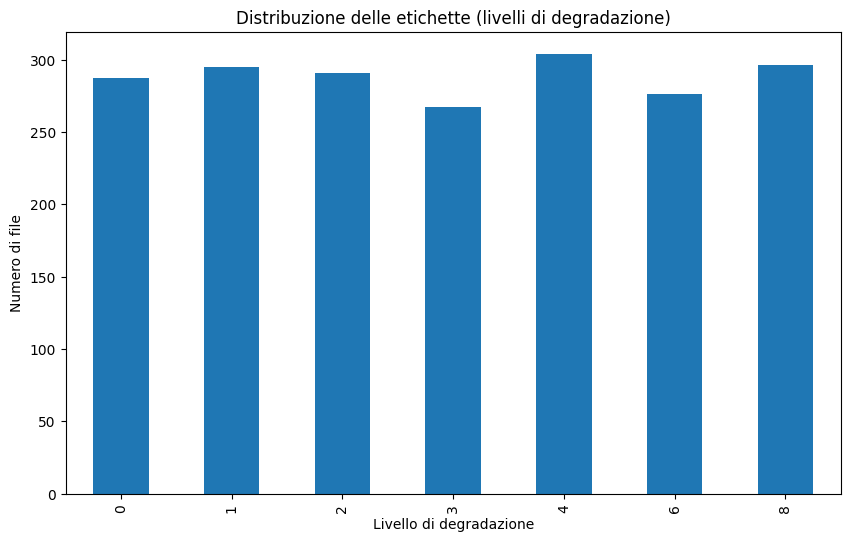

In [42]:
# 4. Distribuzione delle etichette
plt.figure(figsize=(10, 6))
df_stats['etichetta'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuzione delle etichette (livelli di degradazione)')
plt.xlabel('Livello di degradazione')
plt.ylabel('Numero di file')
plt.show()

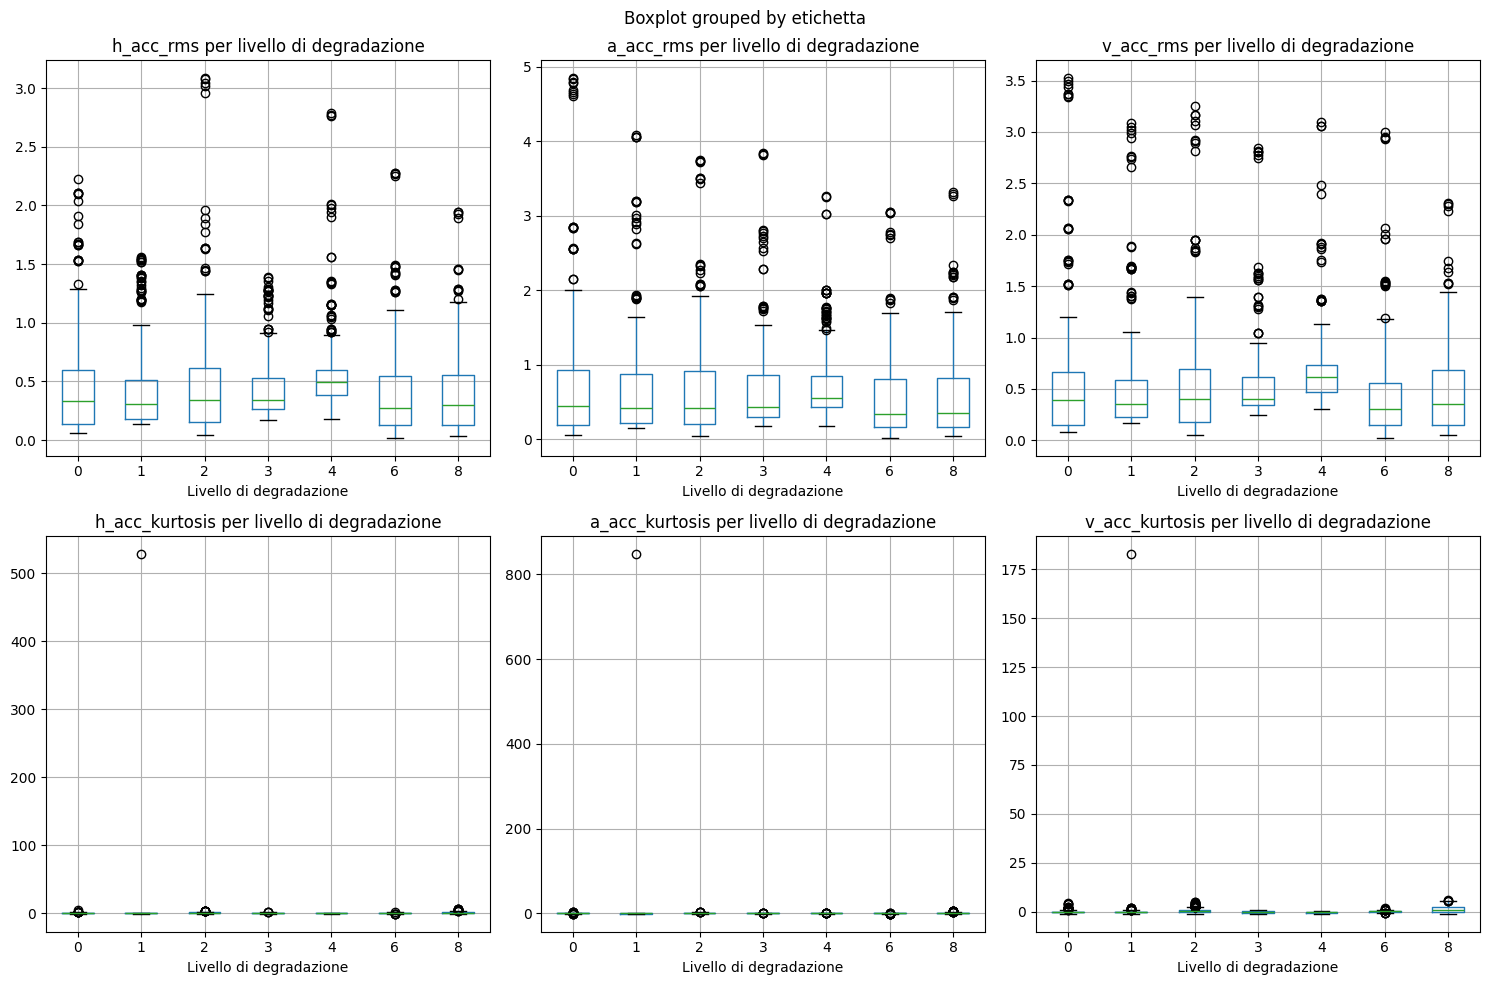

In [43]:
# 5. Analisi delle features per livello di degradazione
features_to_analyze = ['h_acc_rms', 'a_acc_rms', 'v_acc_rms', 
                      'h_acc_kurtosis', 'a_acc_kurtosis', 'v_acc_kurtosis']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_analyze):
    df_stats.boxplot(column=feature, by='etichetta', ax=axes[i])
    axes[i].set_title(f'{feature} per livello di degradazione')
    axes[i].set_xlabel('Livello di degradazione')

plt.tight_layout()
plt.show()

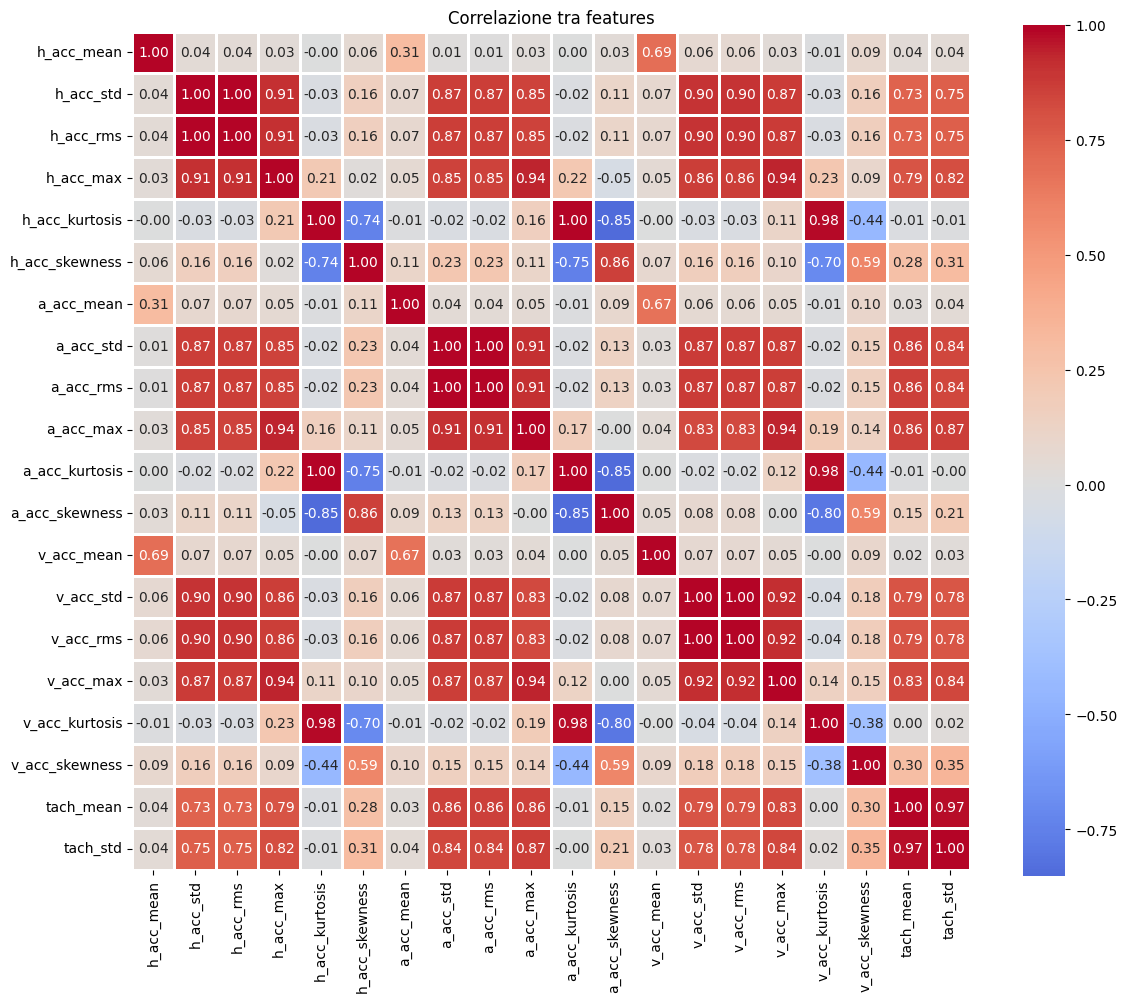

In [44]:
# 6. Correlazione tra features (escludendo metadati)
feature_cols = [col for col in df_stats.columns 
                if col not in ['etichetta', 'velocita', 'torque', 'rep', 
                              'file_path', 'num_samples']]

plt.figure(figsize=(12, 10))
correlation_matrix = df_stats[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlazione tra features')
plt.tight_layout()
plt.show()

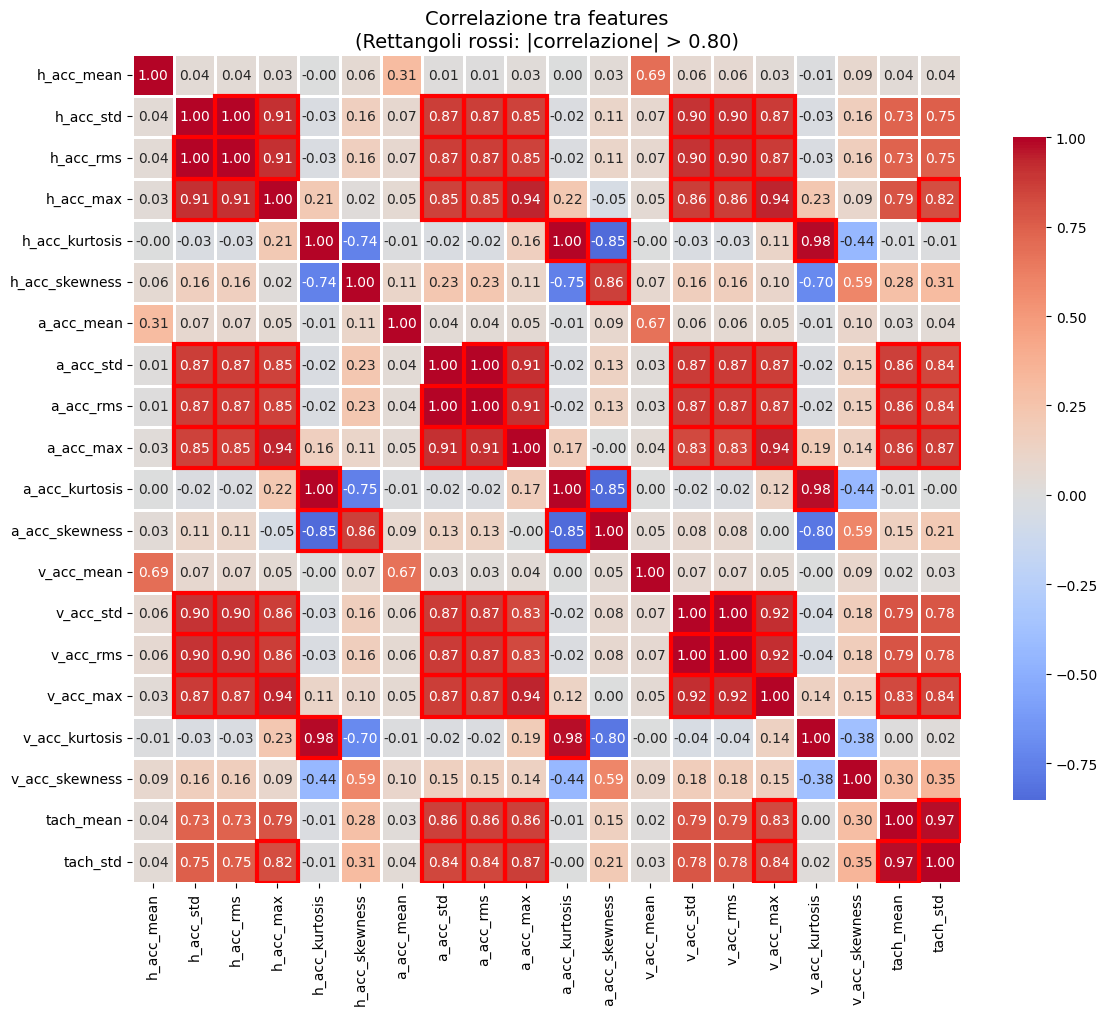

CORRELAZIONI SIGNIFICATIVE (|r| > 0.80):
v_acc_std <-> v_acc_rms: 1.000
a_acc_std <-> a_acc_rms: 1.000
h_acc_std <-> h_acc_rms: 1.000
h_acc_kurtosis <-> a_acc_kurtosis: 0.999
h_acc_kurtosis <-> v_acc_kurtosis: 0.979
a_acc_kurtosis <-> v_acc_kurtosis: 0.978
tach_mean <-> tach_std: 0.974
h_acc_max <-> v_acc_max: 0.935
h_acc_max <-> a_acc_max: 0.935
a_acc_max <-> v_acc_max: 0.935
v_acc_rms <-> v_acc_max: 0.920
v_acc_std <-> v_acc_max: 0.920
a_acc_std <-> a_acc_max: 0.913
a_acc_rms <-> a_acc_max: 0.913
h_acc_std <-> h_acc_max: 0.912
h_acc_rms <-> h_acc_max: 0.912
h_acc_std <-> v_acc_rms: 0.905
h_acc_std <-> v_acc_std: 0.905
h_acc_rms <-> v_acc_rms: 0.905
h_acc_rms <-> v_acc_std: 0.905
h_acc_rms <-> v_acc_max: 0.874
h_acc_std <-> v_acc_max: 0.874
a_acc_std <-> v_acc_rms: 0.871
a_acc_rms <-> v_acc_rms: 0.871
a_acc_std <-> v_acc_std: 0.871
a_acc_rms <-> v_acc_std: 0.871
a_acc_max <-> tach_std: 0.867
h_acc_rms <-> a_acc_std: 0.866
h_acc_std <-> a_acc_std: 0.866
h_acc_rms <-> a_acc_rms: 0.866
h

In [45]:
# 6.1 Correlazione tra features (escludendo metadati)
feature_cols = [col for col in df_stats.columns 
                if col not in ['etichetta', 'velocita', 'torque', 'rep', 
                              'file_path', 'num_samples']]

plt.figure(figsize=(12, 10))

# Calcola la matrice di correlazione
correlation_matrix = df_stats[feature_cols].corr()

# Crea la heatmap
ax = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                 center=0, square=True, linewidths=1, 
                 cbar_kws={"shrink": 0.8})

# Trova le celle con correlazione alta (escludendo la diagonale)
high_corr_threshold = 0.80
low_corr_threshold = -0.80

# Itera attraverso la matrice per trovare correlazioni alte
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        # Salta la diagonale (correlazione di una variabile con se stessa)
        if i != j:
            corr_value = correlation_matrix.iloc[i, j]
            
            # Se la correlazione è alta
            if corr_value > high_corr_threshold or corr_value < low_corr_threshold:
                # Aggiungi un rettangolo rosso
                rect = patches.Rectangle((j, i), 1, 1, 
                                       linewidth=3, 
                                       edgecolor='red', 
                                       facecolor='none',
                                       zorder=10)  # zorder alto per essere sopra la heatmap
                ax.add_patch(rect)

plt.title('Correlazione tra features\n(Rettangoli rossi: |correlazione| > 0.80)', fontsize=14)
plt.tight_layout()
plt.show()

# Stampa anche un report delle correlazioni alte
print("CORRELAZIONI SIGNIFICATIVE (|r| > 0.80):")
print("="*50)

high_correlations = []
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):  # Solo triangolo superiore
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > high_corr_threshold:
            var1 = correlation_matrix.index[i]
            var2 = correlation_matrix.columns[j]
            high_correlations.append((var1, var2, corr_value))

# Ordina per valore assoluto di correlazione (decrescente)
high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

for var1, var2, corr in high_correlations:
    print(f"{var1} <-> {var2}: {corr:.3f}")

print(f"\nTotale coppie con alta correlazione: {len(high_correlations)}")

SELEZIONE FEATURES BASATA SULLA CORRELAZIONE
Numero di features iniziali: 20
Features iniziali: ['h_acc_mean', 'h_acc_std', 'h_acc_rms', 'h_acc_max', 'h_acc_kurtosis', 'h_acc_skewness', 'a_acc_mean', 'a_acc_std', 'a_acc_rms', 'a_acc_max', 'a_acc_kurtosis', 'a_acc_skewness', 'v_acc_mean', 'v_acc_std', 'v_acc_rms', 'v_acc_max', 'v_acc_kurtosis', 'v_acc_skewness', 'tach_mean', 'tach_std']


METODO: first
----------------------------------------
Features selezionate (8): ['h_acc_mean', 'h_acc_std', 'h_acc_kurtosis', 'h_acc_skewness', 'a_acc_mean', 'v_acc_mean', 'v_acc_skewness', 'tach_mean']
Features rimosse (12): ['h_acc_rms', 'v_acc_std', 'a_acc_max', 'v_acc_kurtosis', 'a_acc_skewness', 'h_acc_max', 'v_acc_rms', 'a_acc_rms', 'a_acc_kurtosis', 'v_acc_max', 'tach_std', 'a_acc_std']

METODO: variance
----------------------------------------
Features selezionate (6): ['h_acc_mean', 'a_acc_mean', 'a_acc_max', 'a_acc_kurtosis', 'v_acc_mean', 'v_acc_skewness']
Features rimosse (14): ['h_acc_rms

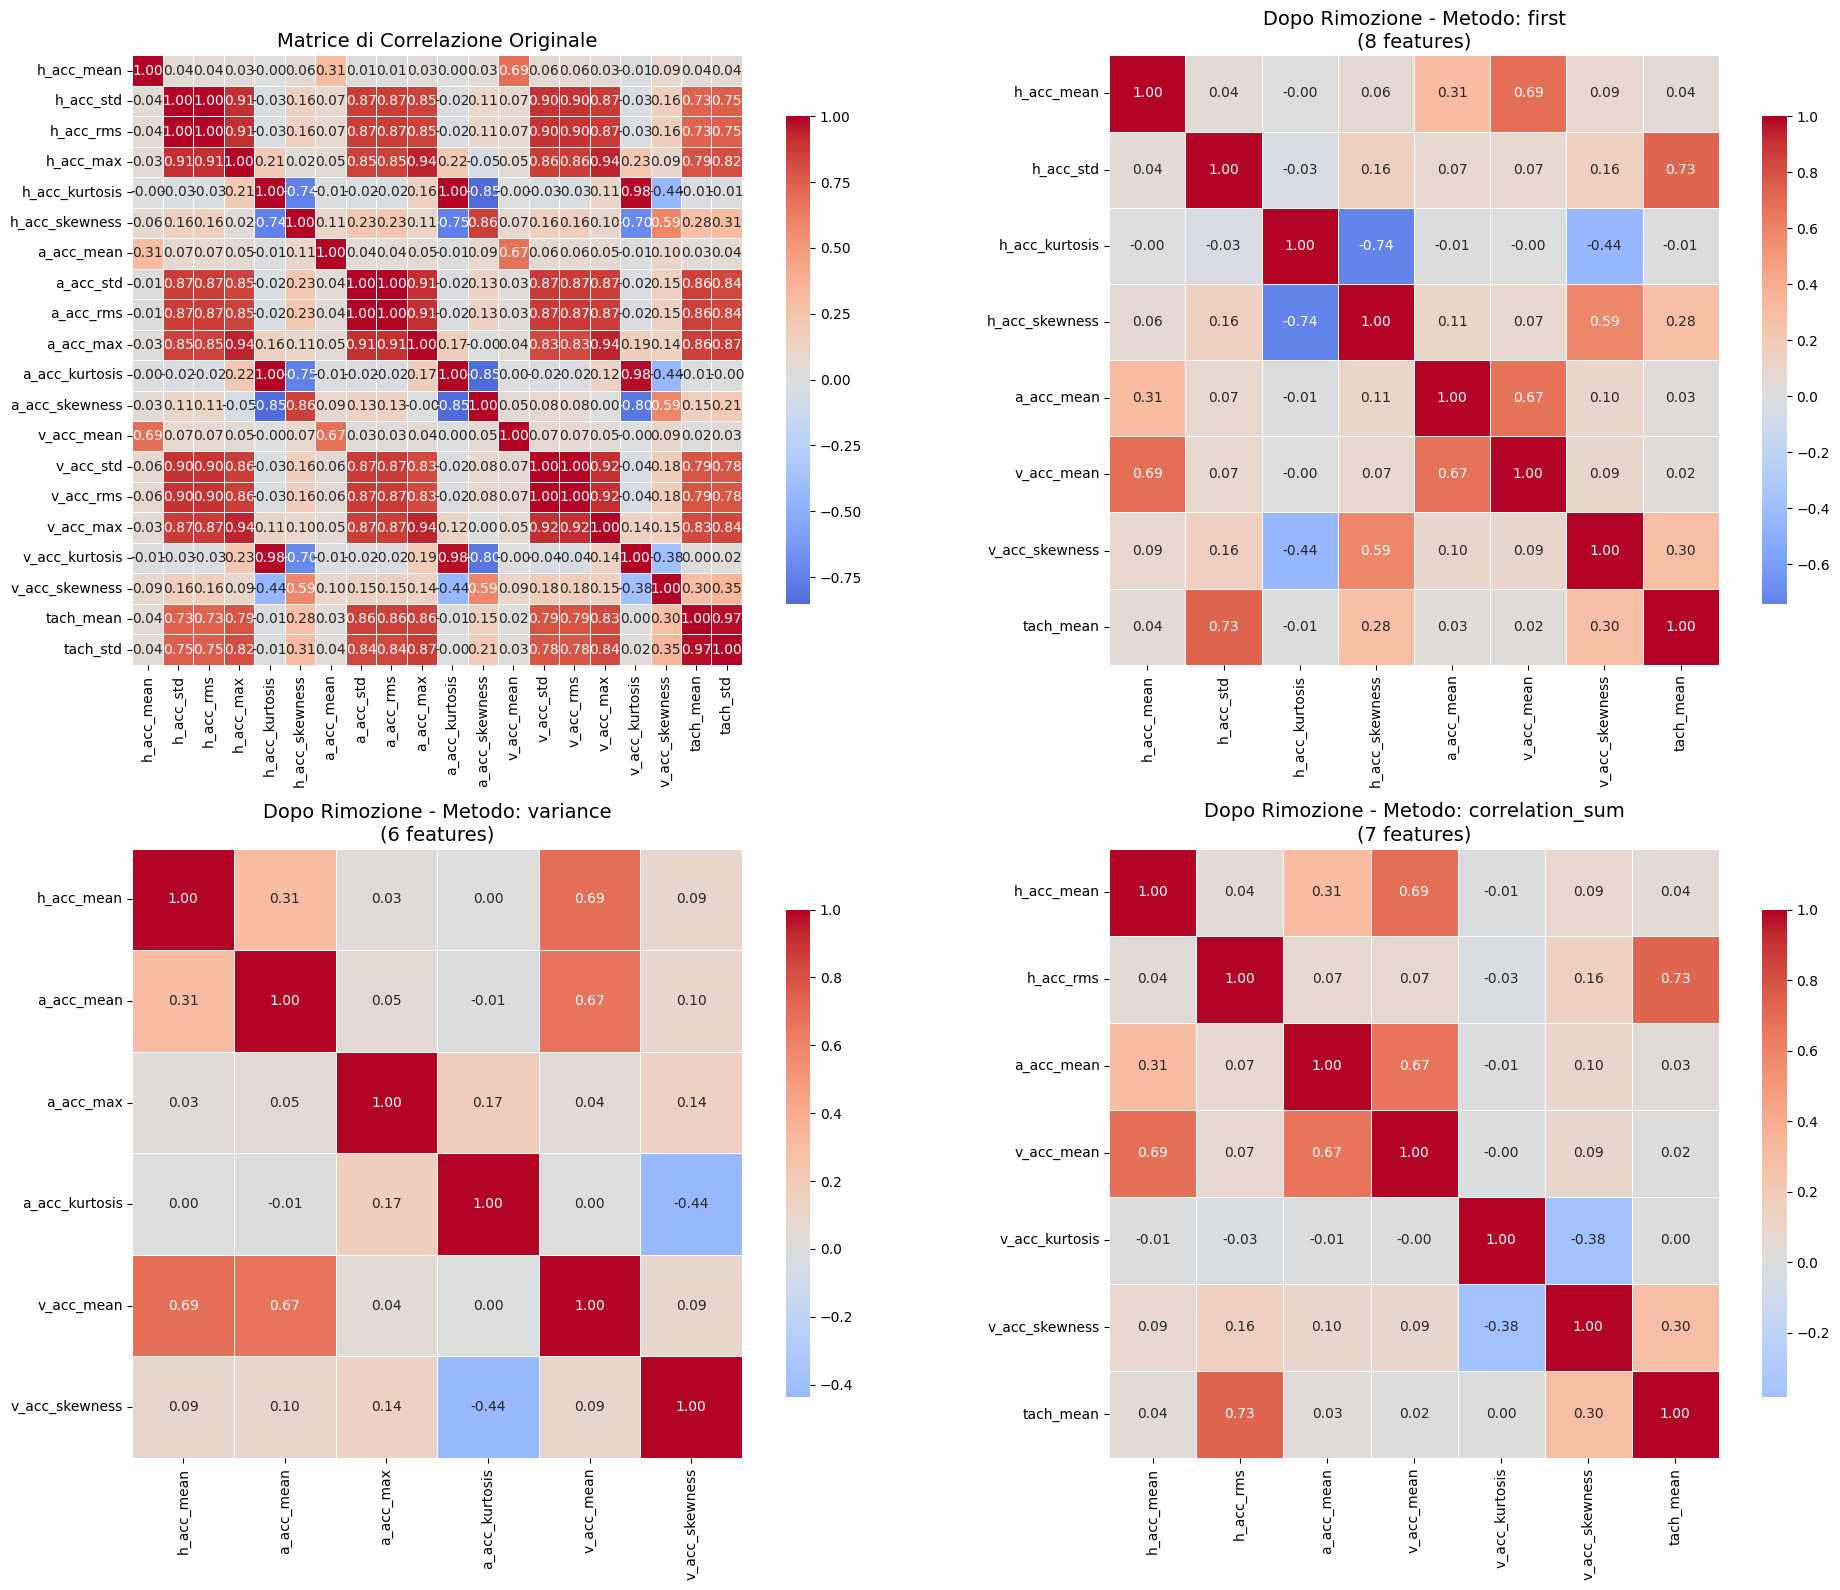



DATAFRAME RIDOTTO CREATO
Metodo utilizzato: variance
Shape originale: (2016, 26)
Shape ridotta: (2016, 12)
Riduzione features: 20 -> 6 (30.0%)

VERIFICA CORRELAZIONI NEL DATASET RIDOTTO:
✓ Tutte le correlazioni sono ora < 0.80


ANALISI FEATURES RIMOSSE:

h_acc_rms:
  Alta correlazione con:
    - h_acc_std: 1.000
    - h_acc_max: 0.912
    - v_acc_rms: 0.905
    - v_acc_std: 0.905
    - v_acc_max: 0.874
    - a_acc_std: 0.866
    - a_acc_rms: 0.866
    - a_acc_max: 0.854

v_acc_std:
  Alta correlazione con:
    - v_acc_rms: 1.000
    - v_acc_max: 0.920
    - h_acc_std: 0.905
    - h_acc_rms: 0.905
    - a_acc_std: 0.871
    - a_acc_rms: 0.871
    - h_acc_max: 0.863
    - a_acc_max: 0.832

v_acc_kurtosis:
  Alta correlazione con:
    - h_acc_kurtosis: 0.979
    - a_acc_kurtosis: 0.978

a_acc_skewness:
  Alta correlazione con:
    - h_acc_skewness: 0.855
    - a_acc_kurtosis: -0.852
    - h_acc_kurtosis: -0.847

h_acc_max:
  Alta correlazione con:
    - v_acc_max: 0.935
    - a_acc_max

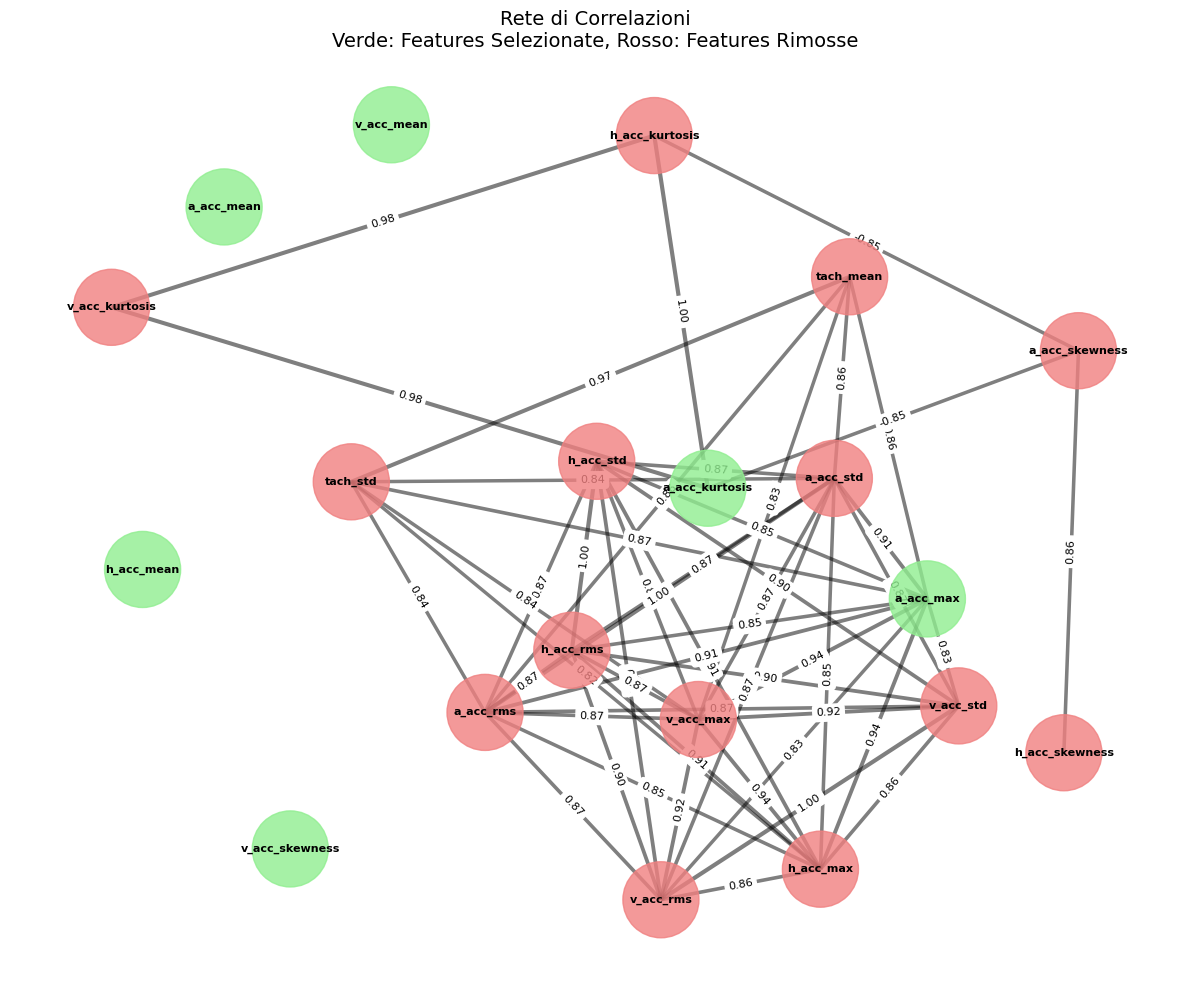



Dataset ridotto salvato come 'vibration_stats_reduced.pkl' e '.csv'


In [48]:
def remove_highly_correlated_features(df, feature_cols, threshold=0.80, method='first'):
    """
    Rimuove le features altamente correlate dal dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Il DataFrame contenente i dati
    feature_cols : list
        Lista delle colonne da considerare per la correlazione
    threshold : float
        Soglia di correlazione (default 0.80)
    method : str
        Metodo per decidere quale feature tenere:
        - 'first': mantiene la prima feature nell'ordine delle colonne
        - 'variance': mantiene la feature con maggiore varianza
        - 'correlation_sum': mantiene la feature con minore somma di correlazioni assolute
    
    Returns:
    --------
    selected_features : list
        Lista delle features selezionate
    removed_features : list
        Lista delle features rimosse
    correlation_matrix : DataFrame
        Matrice di correlazione originale
    """
    
    # Calcola la matrice di correlazione
    correlation_matrix = df[feature_cols].corr()
    
    # Crea una copia della matrice di correlazione
    corr_matrix = correlation_matrix.abs()
    
    # Maschera il triangolo superiore (inclusa la diagonale)
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Lista per tenere traccia delle features da rimuovere
    features_to_drop = set()
    
    # Trova tutte le coppie di features con alta correlazione
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                high_corr_pairs.append((feat1, feat2, corr_matrix.iloc[i, j]))
    
    # Applica il metodo di selezione
    if method == 'first':
        # Mantiene la prima feature nell'ordine
        for feat1, feat2, corr in high_corr_pairs:
            if feat1 not in features_to_drop:
                features_to_drop.add(feat2)
                
    elif method == 'variance':
        # Mantiene la feature con maggiore varianza
        variances = df[feature_cols].var()
        for feat1, feat2, corr in high_corr_pairs:
            if feat1 not in features_to_drop and feat2 not in features_to_drop:
                if variances[feat1] >= variances[feat2]:
                    features_to_drop.add(feat2)
                else:
                    features_to_drop.add(feat1)
                    
    elif method == 'correlation_sum':
        # Mantiene la feature con minore somma di correlazioni assolute
        corr_sums = corr_matrix.sum() - 1  # -1 per escludere l'autocorrelazione
        for feat1, feat2, corr in high_corr_pairs:
            if feat1 not in features_to_drop and feat2 not in features_to_drop:
                if corr_sums[feat1] <= corr_sums[feat2]:
                    features_to_drop.add(feat2)
                else:
                    features_to_drop.add(feat1)
    
    # Features selezionate
    selected_features = [f for f in feature_cols if f not in features_to_drop]
    removed_features = list(features_to_drop)
    
    return selected_features, removed_features, correlation_matrix

# Applicazione della funzione
print("SELEZIONE FEATURES BASATA SULLA CORRELAZIONE")
print("=" * 60)

# Features da analizzare (escludendo metadati)
feature_cols = [col for col in df_stats.columns 
                if col not in ['etichetta', 'velocita', 'torque', 'rep', 
                              'file_path', 'num_samples']]

print(f"Numero di features iniziali: {len(feature_cols)}")
print(f"Features iniziali: {feature_cols}\n")

# Prova diversi metodi
methods = ['first', 'variance', 'correlation_sum']
results = {}

for method in methods:
    print(f"\nMETODO: {method}")
    print("-" * 40)
    
    selected_features, removed_features, corr_matrix = remove_highly_correlated_features(
        df_stats, feature_cols, threshold=0.80, method=method
    )
    
    results[method] = {
        'selected': selected_features,
        'removed': removed_features,
        'corr_matrix': corr_matrix
    }
    
    print(f"Features selezionate ({len(selected_features)}): {selected_features}")
    print(f"Features rimosse ({len(removed_features)}): {removed_features}")

# Visualizza il confronto
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Matrice di correlazione originale
ax = axes[0, 0]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=ax, 
            cbar_kws={"shrink": 0.8})
ax.set_title('Matrice di Correlazione Originale', fontsize=14)

# Plot 2-4: Matrici di correlazione dopo rimozione features
for idx, method in enumerate(methods):
    ax = axes.flatten()[idx + 1]
    selected_features = results[method]['selected']
    
    # Crea matrice di correlazione solo con features selezionate
    reduced_corr = df_stats[selected_features].corr()
    
    sns.heatmap(reduced_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, ax=ax,
                cbar_kws={"shrink": 0.8})
    ax.set_title(f'Dopo Rimozione - Metodo: {method}\n({len(selected_features)} features)', 
                 fontsize=14)

plt.tight_layout()
plt.show()

# Crea il DataFrame ridotto con il metodo migliore
best_method = 'variance'  # Puoi cambiare in base alle tue preferenze
selected_features = results[best_method]['selected']

# Crea il nuovo DataFrame con solo le features selezionate
df_reduced = df_stats[['etichetta', 'velocita', 'torque', 'rep', 'file_path', 'num_samples'] + 
                      selected_features].copy()

print(f"\n\nDATAFRAME RIDOTTO CREATO")
print("=" * 60)
print(f"Metodo utilizzato: {best_method}")
print(f"Shape originale: {df_stats.shape}")
print(f"Shape ridotta: {df_reduced.shape}")
print(f"Riduzione features: {len(feature_cols)} -> {len(selected_features)} ({len(selected_features)/len(feature_cols)*100:.1f}%)")

# Verifica che non ci siano più correlazioni alte
print("\nVERIFICA CORRELAZIONI NEL DATASET RIDOTTO:")
reduced_corr = df_reduced[selected_features].corr()
high_corr_mask = (reduced_corr.abs() > 0.80) & (reduced_corr != 1.0)
if high_corr_mask.any().any():
    print("ATTENZIONE: Ci sono ancora correlazioni > 0.80!")
    high_corr_indices = np.where(high_corr_mask)
    for i, j in zip(high_corr_indices[0], high_corr_indices[1]):
        if i < j:  # Solo triangolo superiore
            print(f"  {reduced_corr.index[i]} <-> {reduced_corr.columns[j]}: {reduced_corr.iloc[i, j]:.3f}")
else:
    print("✓ Tutte le correlazioni sono ora < 0.80")

# Salva il dataset ridotto
df_reduced.to_pickle("vibration_stats_reduced.pkl")
df_reduced.to_csv("vibration_stats_reduced.csv", index=False)

# Analisi dell'importanza delle features rimosse
print("\n\nANALISI FEATURES RIMOSSE:")
print("=" * 60)
removed_features = results[best_method]['removed']
if removed_features:
    # Calcola statistiche per le features rimosse
    for feat in removed_features:
        # Trova con quali features era correlata
        high_corr_with = []
        for other_feat in feature_cols:
            if other_feat != feat:
                corr_val = corr_matrix.loc[feat, other_feat]
                if abs(corr_val) > 0.80:
                    high_corr_with.append((other_feat, corr_val))
        
        print(f"\n{feat}:")
        print(f"  Alta correlazione con:")
        for other_feat, corr_val in sorted(high_corr_with, key=lambda x: abs(x[1]), reverse=True):
            print(f"    - {other_feat}: {corr_val:.3f}")

# Crea un grafico di rete per visualizzare le correlazioni
import networkx as nx

plt.figure(figsize=(12, 10))

# Crea il grafo
G = nx.Graph()

# Aggiungi nodi per tutte le features
for feat in feature_cols:
    G.add_node(feat)

# Aggiungi archi per correlazioni alte
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.80:
            G.add_edge(corr_matrix.index[i], corr_matrix.columns[j], 
                      weight=abs(corr_val), correlation=corr_val)

# Layout del grafo
pos = nx.spring_layout(G, k=2, iterations=50)

# Colora i nodi: verde per selezionate, rosso per rimosse
node_colors = ['lightgreen' if node in selected_features else 'lightcoral' 
               for node in G.nodes()]

# Disegna il grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Disegna gli archi con spessore proporzionale alla correlazione
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], alpha=0.5)

# Aggiungi etichette agli archi con i valori di correlazione
edge_labels = {(u, v): f"{G[u][v]['correlation']:.2f}" for u, v in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

plt.title('Rete di Correlazioni\nVerde: Features Selezionate, Rosso: Features Rimosse', 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n\nDataset ridotto salvato come 'vibration_stats_reduced.pkl' e '.csv'")

In [46]:
!pip install pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
ERROR: No matching distribution found for pywt


In [49]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class AdvancedFeatureExtractor:
    """
    Estrae features avanzate dai segnali di vibrazione per la diagnosi dei guasti.
    Combina features nel dominio del tempo, frequenza e tempo-frequenza.
    """
    
    def __init__(self, fs=20480):
        self.fs = fs
        self.scaler = StandardScaler()
        
    def extract_time_domain_features(self, signal):
        """Estrae features nel dominio del tempo."""
        features = {}
        
        # Statistiche base
        features['mean'] = np.mean(signal)
        features['std'] = np.std(signal)
        features['rms'] = np.sqrt(np.mean(signal**2))
        features['peak'] = np.max(np.abs(signal))
        features['peak2peak'] = np.max(signal) - np.min(signal)
        
        # Fattori di forma
        features['crest_factor'] = features['peak'] / features['rms'] if features['rms'] > 0 else 0
        features['shape_factor'] = features['rms'] / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) > 0 else 0
        features['impulse_factor'] = features['peak'] / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) > 0 else 0
        
        # Momenti statistici
        features['kurtosis'] = kurtosis(signal)
        features['skewness'] = skew(signal)
        
        # Features energetiche
        features['energy'] = np.sum(signal**2)
        features['entropy'] = -np.sum(np.abs(signal) * np.log(np.abs(signal) + 1e-10))
        
        return features
    
    def extract_frequency_domain_features(self, signal, n_bands=10):
        """Estrae features nel dominio della frequenza."""
        features = {}
        
        # FFT
        fft_vals = np.fft.rfft(signal)
        fft_freq = np.fft.rfftfreq(len(signal), 1/self.fs)
        magnitude = np.abs(fft_vals)
        
        # Features spettrali globali
        features['spectral_centroid'] = np.sum(fft_freq * magnitude) / np.sum(magnitude)
        features['spectral_spread'] = np.sqrt(np.sum(((fft_freq - features['spectral_centroid'])**2) * magnitude) / np.sum(magnitude))
        features['spectral_flux'] = np.sum(np.diff(magnitude)**2)
        features['spectral_rolloff'] = fft_freq[np.where(np.cumsum(magnitude) >= 0.85 * np.sum(magnitude))[0][0]]
        
        # Energia per bande di frequenza
        band_edges = np.linspace(0, self.fs/2, n_bands + 1)
        for i in range(n_bands):
            band_mask = (fft_freq >= band_edges[i]) & (fft_freq < band_edges[i+1])
            features[f'band_energy_{i}'] = np.sum(magnitude[band_mask]**2)
        
        # Frequenze dominanti
        peaks, properties = signal.find_peaks(magnitude, height=np.max(magnitude)*0.1)
        if len(peaks) > 0:
            sorted_peaks = peaks[np.argsort(magnitude[peaks])[::-1]]
            for i in range(min(5, len(sorted_peaks))):
                features[f'peak_freq_{i}'] = fft_freq[sorted_peaks[i]]
                features[f'peak_mag_{i}'] = magnitude[sorted_peaks[i]]
        
        return features
    
    def extract_wavelet_features(self, signal, wavelet='db4', levels=5):
        """Estrae features usando la trasformata wavelet."""
        features = {}
        
        # Decomposizione wavelet
        coeffs = pywt.wavedec(signal, wavelet, level=levels)
        
        # Features per ogni livello
        for i, coeff in enumerate(coeffs):
            features[f'wavelet_energy_{i}'] = np.sum(coeff**2)
            features[f'wavelet_entropy_{i}'] = -np.sum(coeff**2 * np.log(coeff**2 + 1e-10))
            features[f'wavelet_std_{i}'] = np.std(coeff)
        
        return features
    
    def extract_envelope_features(self, signal):
        """Estrae features dall'envelope del segnale (utile per bearing faults)."""
        features = {}
        
        # Hilbert transform per l'envelope
        analytic_signal = signal.hilbert(signal)
        envelope = np.abs(analytic_signal)
        
        # Features dall'envelope
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_std'] = np.std(envelope)
        features['envelope_peak'] = np.max(envelope)
        features['envelope_kurtosis'] = kurtosis(envelope)
        
        return features
    
    def extract_all_features(self, signal):
        """Estrae tutte le features combinate."""
        all_features = {}
        
        # Preprocessamento
        signal = signal - np.mean(signal)  # Rimuovi DC
        
        # Estrai tutti i tipi di features
        all_features.update(self.extract_time_domain_features(signal))
        all_features.update(self.extract_frequency_domain_features(signal))
        all_features.update(self.extract_wavelet_features(signal))
        all_features.update(self.extract_envelope_features(signal))
        
        return all_features

def create_windowed_features(file_path, window_size=2048, overlap=0.5, max_windows=50):
    """
    Crea features usando finestre scorrevoli sul segnale.
    Questo aumenta significativamente il numero di campioni per training.
    
    Parameters:
    -----------
    file_path : str
        Path del file da processare
    window_size : int
        Dimensione della finestra in campioni
    overlap : float
        Percentuale di overlap tra finestre (0-1)
    max_windows : int
        Numero massimo di finestre da estrarre per file
    """
    
    # Carica i dati
    data = np.loadtxt(file_path)
    
    # Parametri finestra
    step_size = int(window_size * (1 - overlap))
    n_windows = min(max_windows, (len(data) - window_size) // step_size + 1)
    
    # Estrai features per ogni finestra e ogni asse
    feature_extractor = AdvancedFeatureExtractor()
    window_features = []
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        
        if end_idx > len(data):
            break
            
        window_data = data[start_idx:end_idx]
        
        # Features per ogni asse
        features = {}
        axes = ['h', 'a', 'v']  # horizontal, axial, vertical
        
        for axis_idx, axis_name in enumerate(axes):
            axis_features = feature_extractor.extract_all_features(window_data[:, axis_idx])
            # Aggiungi prefisso per identificare l'asse
            for feat_name, feat_val in axis_features.items():
                features[f'{axis_name}_{feat_name}'] = feat_val
        
        # Features cross-axis
        features['cross_correlation_ha'] = np.correlate(window_data[:, 0], window_data[:, 1], mode='valid')[0]
        features['cross_correlation_hv'] = np.correlate(window_data[:, 0], window_data[:, 2], mode='valid')[0]
        features['cross_correlation_av'] = np.correlate(window_data[:, 1], window_data[:, 2], mode='valid')[0]
        
        window_features.append(features)
    
    return window_features

def build_enhanced_dataset(root_path, save_path='enhanced_features.pkl'):
    """
    Costruisce un dataset enhanced con molti più campioni usando windowing.
    """
    
    print("Building enhanced dataset with windowed features...")
    
    all_data = []
    
    # Prima, identifica tutti i file
    file_list = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                
                # Estrai metadata
                folder_name = os.path.basename(root)
                if 'Pitting_degradation_level_' in folder_name:
                    label = int(folder_name.replace('Pitting_degradation_level_', '').split('(')[0].strip())
                else:
                    continue
                
                # Parse filename
                pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                match = re.search(pattern, file)
                if match:
                    speed = int(match.group(1))
                    torque = int(match.group(2))
                    rep = int(match.group(3))
                    
                    file_list.append({
                        'path': file_path,
                        'label': label,
                        'speed': speed,
                        'torque': torque,
                        'rep': rep
                    })
    
    print(f"Found {len(file_list)} files to process")
    
    # Processa ogni file
    for file_info in tqdm(file_list, desc="Processing files"):
        try:
            # Estrai features windowed
            window_features = create_windowed_features(
                file_info['path'],
                window_size=2048,  # ~0.1 secondi @ 20480 Hz
                overlap=0.5,
                max_windows=50  # 50 windows per file = 100,800 campioni totali invece di 2,016
            )
            
            # Aggiungi metadata a ogni window
            for features in window_features:
                features.update({
                    'label': file_info['label'],
                    'speed': file_info['speed'],
                    'torque': file_info['torque'],
                    'rep': file_info['rep'],
                    'file_path': file_info['path']
                })
                all_data.append(features)
                
        except Exception as e:
            print(f"Error processing {file_info['path']}: {e}")
            continue
    
    # Crea DataFrame
    df_enhanced = pd.DataFrame(all_data)
    
    print(f"\nEnhanced dataset created:")
    print(f"Total samples: {len(df_enhanced)} (vs original 2,016)")
    print(f"Features per sample: {len(df_enhanced.columns) - 5}")  # -5 for metadata
    print(f"Samples per class:")
    print(df_enhanced['label'].value_counts().sort_index())
    
    # Salva
    df_enhanced.to_pickle(save_path)
    
    return df_enhanced

# Pipeline completo
def prepare_for_modeling(df_enhanced):
    """
    Prepara i dati per il modeling, gestendo le classi mancanti.
    """
    
    # Separa features e metadata
    feature_cols = [col for col in df_enhanced.columns 
                   if col not in ['label', 'speed', 'torque', 'rep', 'file_path']]
    
    X = df_enhanced[feature_cols]
    y = df_enhanced['label']
    metadata = df_enhanced[['speed', 'torque', 'rep', 'file_path']]
    
    # Gestisci valori mancanti
    X = X.fillna(0)
    
    # Normalizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Crea mapping per le classi mancanti
    # Le classi 5,7,9,10 sono mancanti nel training
    known_classes = [0, 1, 2, 3, 4, 6, 8]
    
    # Strategy: usa interpolazione per predire classi mancanti
    # Esempio: classe 5 potrebbe essere interpolata tra 4 e 6
    
    print(f"\nData prepared for modeling:")
    print(f"X shape: {X_scaled.shape}")
    print(f"Known classes: {known_classes}")
    print(f"Missing classes to predict: [5, 7, 9, 10]")
    
    return X_scaled, y, metadata, scaler, feature_cols

# Esempio di utilizzo
if __name__ == "__main__":
    # 1. Crea dataset enhanced
    df_enhanced = build_enhanced_dataset(ROOT_TRAIN_DATA_FOLDER)
    
    # 2. Prepara per modeling
    X, y, metadata, scaler, feature_cols = prepare_for_modeling(df_enhanced)
    
    print("\nReady for advanced modeling!")

Building enhanced dataset with windowed features...
Found 2016 files to process


Processing files:   0%|          | 1/2016 [00:00<03:36,  9.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   0%|          | 5/2016 [00:00<02:53, 11.57it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:   1%|          | 11/2016 [00:00<01:38, 20.44it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:   1%|          | 18/2016 [00:01<01:30, 22.17it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   1%|          | 21/2016 [00:01<01:27, 22.90it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   1%|▏         | 28/2016 [00:01<01:18, 25.22it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   2%|▏         | 34/2016 [00:01<01:15, 26.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   2%|▏         | 40/2016 [00:01<01:15, 26.26it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   2%|▏         | 46/2016 [00:02<01:14, 26.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   3%|▎         | 52/2016 [00:02<01:14, 26.54it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:   3%|▎         | 58/2016 [00:02<01:24, 23.25it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   3%|▎         | 62/2016 [00:02<01:23, 23.52it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   3%|▎         | 68/2016 [00:02<01:18, 24.88it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:   4%|▎         | 74/2016 [00:03<01:17, 25.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   4%|▍         | 80/2016 [00:03<01:14, 25.99it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   4%|▍         | 86/2016 [00:03<01:22, 23.45it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   5%|▍         | 92/2016 [00:03<01:17, 24.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   5%|▍         | 99/2016 [00:04<01:06, 28.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:   5%|▌         | 102/2016 [00:04<01:10, 27.32it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   5%|▌         | 108/2016 [00:04<01:20, 23.84it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:   6%|▌         | 114/2016 [00:04<01:19, 23.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   6%|▌         | 117/2016 [00:05<01:40, 18.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   6%|▌         | 123/2016 [00:05<01:29, 21.16it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   6%|▋         | 126/2016 [00:05<01:40, 18.86it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   7%|▋         | 132/2016 [00:05<01:28, 21.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:   7%|▋         | 138/2016 [00:06<01:21, 23.05it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:   7%|▋         | 145/2016 [00:06<01:08, 27.42it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:   7%|▋         | 151/2016 [00:06<01:17, 23.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   8%|▊         | 154/2016 [00:06<01:28, 21.05it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   8%|▊         | 160/2016 [00:06<01:26, 21.47it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   8%|▊         | 163/2016 [00:07<01:23, 22.23it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   8%|▊         | 169/2016 [00:07<01:30, 20.34it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   9%|▊         | 175/2016 [00:07<01:24, 21.79it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V400_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   9%|▉         | 178/2016 [00:07<01:22, 22.39it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   9%|▉         | 184/2016 [00:08<01:24, 21.57it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:   9%|▉         | 190/2016 [00:08<01:18, 23.40it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  10%|▉         | 193/2016 [00:08<01:18, 23.20it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  10%|▉         | 196/2016 [00:08<01:30, 20.13it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  10%|█         | 202/2016 [00:08<01:19, 22.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  10%|█         | 209/2016 [00:09<01:14, 24.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V3000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  11%|█         | 212/2016 [00:09<01:28, 20.29it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  11%|█         | 218/2016 [00:09<01:23, 21.64it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  11%|█         | 221/2016 [00:09<01:24, 21.19it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  11%|█▏        | 228/2016 [00:10<01:21, 22.02it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  12%|█▏        | 235/2016 [00:10<01:12, 24.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  12%|█▏        | 238/2016 [00:10<01:24, 21.03it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  12%|█▏        | 244/2016 [00:10<01:16, 23.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  12%|█▏        | 250/2016 [00:11<01:13, 23.93it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  13%|█▎        | 256/2016 [00:11<01:15, 23.28it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  13%|█▎        | 262/2016 [00:11<01:07, 25.86it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  13%|█▎        | 268/2016 [00:11<01:07, 25.97it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  14%|█▎        | 274/2016 [00:12<01:19, 21.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  14%|█▍        | 278/2016 [00:12<01:10, 24.62it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  14%|█▍        | 285/2016 [00:12<01:04, 26.95it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V700_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V800_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  14%|█▍        | 288/2016 [00:12<01:15, 22.88it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V900_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  15%|█▍        | 294/2016 [00:12<01:16, 22.58it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  15%|█▍        | 300/2016 [00:13<01:17, 22.03it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  15%|█▌        | 303/2016 [00:13<01:18, 21.93it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  15%|█▌        | 309/2016 [00:13<01:21, 20.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  15%|█▌        | 312/2016 [00:13<01:18, 21.79it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  16%|█▌        | 318/2016 [00:13<01:11, 23.90it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  16%|█▌        | 324/2016 [00:14<01:20, 21.02it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  16%|█▋        | 330/2016 [00:14<01:12, 23.13it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  17%|█▋        | 333/2016 [00:14<01:17, 21.77it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  17%|█▋        | 340/2016 [00:14<01:08, 24.50it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  17%|█▋        | 346/2016 [00:15<01:04, 25.75it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  17%|█▋        | 352/2016 [00:15<01:12, 22.84it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  18%|█▊        | 358/2016 [00:15<01:07, 24.70it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  18%|█▊        | 364/2016 [00:15<01:07, 24.37it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  18%|█▊        | 367/2016 [00:15<01:13, 22.41it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  19%|█▊        | 373/2016 [00:16<01:15, 21.73it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  19%|█▉        | 380/2016 [00:16<01:03, 25.87it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  19%|█▉        | 383/2016 [00:16<01:09, 23.47it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  19%|█▉        | 389/2016 [00:16<01:07, 24.24it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  19%|█▉        | 392/2016 [00:17<01:10, 23.00it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  20%|█▉        | 398/2016 [00:17<01:16, 21.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  20%|██        | 404/2016 [00:17<01:14, 21.62it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  20%|██        | 410/2016 [00:17<01:09, 23.08it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  20%|██        | 413/2016 [00:17<01:11, 22.35it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  21%|██        | 420/2016 [00:18<01:00, 26.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  21%|██        | 426/2016 [00:18<01:06, 23.88it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  21%|██▏       | 429/2016 [00:18<01:06, 24.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  22%|██▏       | 435/2016 [00:18<01:08, 23.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  22%|██▏       | 441/2016 [00:19<01:06, 23.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  22%|██▏       | 444/2016 [00:19<01:22, 19.16it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  22%|██▏       | 450/2016 [00:19<01:17, 20.10it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  22%|██▏       | 453/2016 [00:19<01:16, 20.34it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  23%|██▎       | 459/2016 [00:20<01:13, 21.11it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  23%|██▎       | 465/2016 [00:20<01:09, 22.43it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  23%|██▎       | 471/2016 [00:20<01:01, 25.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  24%|██▎       | 477/2016 [00:20<01:05, 23.40it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  24%|██▍       | 483/2016 [00:21<01:01, 24.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V400_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  24%|██▍       | 486/2016 [00:21<00:59, 25.73it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V3000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V500_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  24%|██▍       | 492/2016 [00:21<01:09, 21.78it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  25%|██▍       | 499/2016 [00:21<00:57, 26.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  25%|██▌       | 505/2016 [00:21<00:58, 25.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  25%|██▌       | 508/2016 [00:22<00:56, 26.79it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  25%|██▌       | 514/2016 [00:22<01:07, 22.39it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  26%|██▌       | 517/2016 [00:22<01:04, 23.26it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  26%|██▌       | 524/2016 [00:22<01:00, 24.60it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  26%|██▋       | 531/2016 [00:23<00:57, 25.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  27%|██▋       | 537/2016 [00:23<00:56, 26.30it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  27%|██▋       | 543/2016 [00:23<00:53, 27.75it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V900_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  27%|██▋       | 546/2016 [00:23<00:59, 24.58it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  27%|██▋       | 552/2016 [00:23<01:02, 23.42it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V300_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  28%|██▊       | 559/2016 [00:24<00:57, 25.45it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V700_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V800_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  28%|██▊       | 565/2016 [00:24<00:59, 24.47it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  28%|██▊       | 568/2016 [00:24<01:01, 23.71it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  29%|██▊       | 575/2016 [00:24<01:03, 22.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  29%|██▉       | 581/2016 [00:25<01:01, 23.45it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  29%|██▉       | 587/2016 [00:25<00:57, 24.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  29%|██▉       | 591/2016 [00:25<00:52, 27.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  30%|██▉       | 597/2016 [00:25<00:59, 24.04it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  30%|██▉       | 603/2016 [00:25<00:59, 23.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  30%|███       | 609/2016 [00:26<01:02, 22.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  31%|███       | 615/2016 [00:26<01:00, 23.30it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  31%|███       | 621/2016 [00:26<00:57, 24.06it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  31%|███       | 624/2016 [00:26<01:00, 23.19it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  31%|███▏      | 630/2016 [00:27<00:57, 24.02it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  32%|███▏      | 636/2016 [00:27<00:54, 25.24it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  32%|███▏      | 642/2016 [00:27<00:58, 23.43it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  32%|███▏      | 648/2016 [00:27<00:56, 24.39it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  32%|███▏      | 652/2016 [00:27<00:48, 28.10it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  33%|███▎      | 659/2016 [00:28<00:49, 27.35it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  33%|███▎      | 665/2016 [00:28<00:54, 25.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  33%|███▎      | 668/2016 [00:28<00:54, 24.80it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  33%|███▎      | 671/2016 [00:28<01:08, 19.72it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  34%|███▎      | 678/2016 [00:29<00:59, 22.54it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  34%|███▍      | 681/2016 [00:29<01:10, 18.89it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  34%|███▍      | 687/2016 [00:29<01:02, 21.37it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  34%|███▍      | 690/2016 [00:29<00:57, 23.19it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  35%|███▍      | 696/2016 [00:30<01:02, 21.06it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  35%|███▍      | 703/2016 [00:30<00:53, 24.73it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  35%|███▌      | 706/2016 [00:30<00:55, 23.76it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  35%|███▌      | 712/2016 [00:30<00:54, 24.05it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  35%|███▌      | 715/2016 [00:30<00:55, 23.33it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  36%|███▌      | 721/2016 [00:31<00:59, 21.76it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  36%|███▌      | 727/2016 [00:31<01:04, 20.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  36%|███▌      | 730/2016 [00:31<01:12, 17.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  37%|███▋      | 736/2016 [00:31<01:03, 20.19it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  37%|███▋      | 742/2016 [00:32<00:56, 22.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  37%|███▋      | 745/2016 [00:32<00:59, 21.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  37%|███▋      | 751/2016 [00:32<00:59, 21.24it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  38%|███▊      | 758/2016 [00:32<00:55, 22.85it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  38%|███▊      | 761/2016 [00:33<01:02, 20.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  38%|███▊      | 768/2016 [00:33<00:52, 23.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V3000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  38%|███▊      | 772/2016 [00:33<00:48, 25.47it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V400_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  39%|███▊      | 778/2016 [00:33<00:55, 22.40it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  39%|███▊      | 781/2016 [00:33<01:02, 19.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  39%|███▉      | 787/2016 [00:34<00:57, 21.30it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  39%|███▉      | 791/2016 [00:34<00:50, 24.28it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  40%|███▉      | 797/2016 [00:34<00:48, 25.07it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  40%|███▉      | 804/2016 [00:34<00:54, 22.20it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  40%|████      | 807/2016 [00:35<00:52, 22.86it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  40%|████      | 814/2016 [00:35<00:46, 25.60it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  41%|████      | 820/2016 [00:35<00:47, 25.30it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  41%|████      | 827/2016 [00:35<00:48, 24.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  41%|████▏     | 833/2016 [00:35<00:44, 26.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  42%|████▏     | 839/2016 [00:36<00:42, 27.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  42%|████▏     | 842/2016 [00:36<00:47, 24.70it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  42%|████▏     | 849/2016 [00:36<00:44, 26.49it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V300_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  42%|████▏     | 853/2016 [00:36<00:42, 27.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V700_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V1200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  43%|████▎     | 859/2016 [00:37<00:47, 24.52it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V600_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  43%|████▎     | 862/2016 [00:37<00:44, 25.71it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V900_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_4/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  43%|████▎     | 868/2016 [00:37<00:48, 23.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  43%|████▎     | 874/2016 [00:37<00:48, 23.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  44%|████▎     | 880/2016 [00:37<00:52, 21.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  44%|████▍     | 883/2016 [00:38<00:52, 21.63it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  44%|████▍     | 889/2016 [00:38<00:52, 21.61it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  44%|████▍     | 895/2016 [00:38<00:45, 24.78it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  45%|████▍     | 901/2016 [00:38<00:43, 25.84it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  45%|████▍     | 904/2016 [00:39<00:52, 21.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  45%|████▌     | 910/2016 [00:39<00:51, 21.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  45%|████▌     | 917/2016 [00:39<00:43, 25.38it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  46%|████▌     | 920/2016 [00:39<00:41, 26.20it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  46%|████▌     | 926/2016 [00:39<00:48, 22.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  46%|████▌     | 929/2016 [00:40<00:51, 21.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  46%|████▋     | 935/2016 [00:40<00:45, 23.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  47%|████▋     | 941/2016 [00:40<00:43, 24.58it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  47%|████▋     | 947/2016 [00:40<00:46, 22.76it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  47%|████▋     | 950/2016 [00:40<00:47, 22.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  47%|████▋     | 957/2016 [00:41<00:39, 26.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  48%|████▊     | 963/2016 [00:41<00:40, 26.25it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  48%|████▊     | 966/2016 [00:41<00:49, 21.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  48%|████▊     | 972/2016 [00:41<00:46, 22.69it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  48%|████▊     | 975/2016 [00:42<00:52, 19.75it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  49%|████▊     | 981/2016 [00:42<00:48, 21.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  49%|████▉     | 984/2016 [00:42<00:44, 23.38it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  49%|████▉     | 987/2016 [00:42<00:47, 21.69it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  49%|████▉     | 993/2016 [00:42<00:50, 20.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  49%|████▉     | 996/2016 [00:43<00:53, 18.99it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  50%|████▉     | 1003/2016 [00:43<00:43, 23.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  50%|█████     | 1009/2016 [00:43<00:44, 22.85it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  50%|█████     | 1012/2016 [00:43<00:41, 24.04it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  50%|█████     | 1018/2016 [00:44<00:45, 21.83it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  51%|█████     | 1024/2016 [00:44<00:42, 23.23it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  51%|█████     | 1027/2016 [00:44<00:42, 23.50it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  51%|█████     | 1030/2016 [00:44<00:49, 19.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  51%|█████▏    | 1036/2016 [00:44<00:45, 21.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  52%|█████▏    | 1042/2016 [00:45<00:43, 22.49it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  52%|█████▏    | 1048/2016 [00:45<00:46, 20.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  52%|█████▏    | 1055/2016 [00:45<00:39, 24.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  52%|█████▏    | 1058/2016 [00:45<00:37, 25.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V3000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  53%|█████▎    | 1064/2016 [00:46<00:46, 20.67it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  53%|█████▎    | 1068/2016 [00:46<00:40, 23.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V400_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  53%|█████▎    | 1071/2016 [00:46<00:46, 20.25it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  53%|█████▎    | 1077/2016 [00:46<00:45, 20.70it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  54%|█████▎    | 1083/2016 [00:46<00:39, 23.87it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  54%|█████▍    | 1089/2016 [00:47<00:40, 22.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  54%|█████▍    | 1095/2016 [00:47<00:39, 23.07it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  54%|█████▍    | 1098/2016 [00:47<00:42, 21.48it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  55%|█████▍    | 1104/2016 [00:47<00:39, 23.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  55%|█████▌    | 1110/2016 [00:48<00:36, 24.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  55%|█████▌    | 1116/2016 [00:48<00:36, 24.41it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  56%|█████▌    | 1119/2016 [00:48<00:40, 22.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  56%|█████▌    | 1125/2016 [00:48<00:38, 23.04it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  56%|█████▌    | 1131/2016 [00:48<00:35, 24.76it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  56%|█████▋    | 1137/2016 [00:49<00:37, 23.24it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V900_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  57%|█████▋    | 1143/2016 [00:49<00:35, 24.29it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  57%|█████▋    | 1150/2016 [00:49<00:31, 27.83it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V300_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  57%|█████▋    | 1153/2016 [00:49<00:34, 25.19it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V800_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  57%|█████▋    | 1156/2016 [00:50<00:37, 22.84it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V600_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_8/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  58%|█████▊    | 1163/2016 [00:50<00:36, 23.07it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM202

Processing files:  58%|█████▊    | 1169/2016 [00:50<00:34, 24.59it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  58%|█████▊    | 1175/2016 [00:50<00:36, 22.80it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  59%|█████▊    | 1181/2016 [00:51<00:32, 25.67it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  59%|█████▉    | 1187/2016 [00:51<00:31, 25.96it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  59%|█████▉    | 1193/2016 [00:51<00:31, 26.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  59%|█████▉    | 1196/2016 [00:51<00:33, 24.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  60%|█████▉    | 1203/2016 [00:51<00:33, 24.62it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  60%|██████    | 1210/2016 [00:52<00:30, 26.05it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  60%|██████    | 1213/2016 [00:52<00:34, 23.47it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  60%|██████    | 1219/2016 [00:52<00:35, 22.17it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  61%|██████    | 1225/2016 [00:52<00:35, 22.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  61%|██████    | 1231/2016 [00:53<00:34, 22.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  61%|██████▏   | 1237/2016 [00:53<00:31, 24.42it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  62%|██████▏   | 1240/2016 [00:53<00:31, 24.39it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  62%|██████▏   | 1246/2016 [00:53<00:32, 23.86it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  62%|██████▏   | 1253/2016 [00:53<00:27, 27.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  62%|██████▏   | 1256/2016 [00:54<00:28, 26.85it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  63%|██████▎   | 1262/2016 [00:54<00:34, 21.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  63%|██████▎   | 1265/2016 [00:54<00:33, 22.25it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  63%|██████▎   | 1268/2016 [00:54<00:40, 18.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  63%|██████▎   | 1274/2016 [00:54<00:33, 21.88it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  63%|██████▎   | 1277/2016 [00:55<00:32, 22.59it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  64%|██████▎   | 1283/2016 [00:55<00:35, 20.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  64%|██████▍   | 1289/2016 [00:55<00:32, 22.24it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  64%|██████▍   | 1296/2016 [00:55<00:26, 26.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_P

Processing files:  65%|██████▍   | 1302/2016 [00:56<00:28, 25.44it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  65%|██████▍   | 1305/2016 [00:56<00:28, 24.76it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  65%|██████▍   | 1308/2016 [00:56<00:34, 20.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  65%|██████▌   | 1314/2016 [00:56<00:31, 22.04it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  65%|██████▌   | 1320/2016 [00:56<00:29, 23.22it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  66%|██████▌   | 1323/2016 [00:57<00:34, 20.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  66%|██████▌   | 1329/2016 [00:57<00:31, 21.52it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  66%|██████▌   | 1335/2016 [00:57<00:29, 22.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  67%|██████▋   | 1342/2016 [00:57<00:26, 25.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  67%|██████▋   | 1348/2016 [00:58<00:26, 25.54it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  67%|██████▋   | 1354/2016 [00:58<00:28, 23.57it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V3000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  67%|██████▋   | 1360/2016 [00:58<00:25, 26.22it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V400_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  68%|██████▊   | 1366/2016 [00:58<00:24, 26.77it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  68%|██████▊   | 1369/2016 [00:59<00:27, 23.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  68%|██████▊   | 1375/2016 [00:59<00:30, 21.03it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  69%|██████▊   | 1381/2016 [00:59<00:25, 24.59it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  69%|██████▉   | 1387/2016 [00:59<00:25, 25.09it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  69%|██████▉   | 1393/2016 [01:00<00:22, 27.13it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  69%|██████▉   | 1396/2016 [01:00<00:29, 21.25it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  70%|██████▉   | 1402/2016 [01:00<00:25, 23.80it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  70%|██████▉   | 1408/2016 [01:00<00:24, 24.78it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  70%|███████   | 1415/2016 [01:00<00:21, 27.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  70%|███████   | 1421/2016 [01:01<00:23, 25.79it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  71%|███████   | 1427/2016 [01:01<00:22, 26.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  71%|███████   | 1433/2016 [01:01<00:21, 26.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  71%|███████   | 1436/2016 [01:01<00:24, 23.85it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  72%|███████▏  | 1442/2016 [01:02<00:23, 23.94it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V300_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM20

Processing files:  72%|███████▏  | 1449/2016 [01:02<00:21, 25.84it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V700_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V1200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V800_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  72%|███████▏  | 1452/2016 [01:02<00:23, 23.61it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V600_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V900_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_1/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  72%|███████▏  | 1458/2016 [01:02<00:23, 24.13it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  73%|███████▎  | 1464/2016 [01:02<00:23, 23.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  73%|███████▎  | 1467/2016 [01:03<00:23, 23.00it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  73%|███████▎  | 1473/2016 [01:03<00:23, 23.11it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  73%|███████▎  | 1479/2016 [01:03<00:21, 24.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  74%|███████▎  | 1485/2016 [01:03<00:21, 24.33it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  74%|███████▍  | 1488/2016 [01:03<00:21, 24.40it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  74%|███████▍  | 1495/2016 [01:04<00:19, 26.08it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  74%|███████▍  | 1501/2016 [01:04<00:20, 24.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  75%|███████▍  | 1508/2016 [01:04<00:17, 28.38it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  75%|███████▍  | 1511/2016 [01:04<00:20, 24.91it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  75%|███████▌  | 1517/2016 [01:05<00:19, 25.64it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  76%|███████▌  | 1523/2016 [01:05<00:19, 25.81it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  76%|███████▌  | 1529/2016 [01:05<00:17, 27.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  76%|███████▌  | 1535/2016 [01:05<00:20, 22.93it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  76%|███████▋  | 1542/2016 [01:06<00:17, 27.26it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  77%|███████▋  | 1548/2016 [01:06<00:19, 24.50it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  77%|███████▋  | 1554/2016 [01:06<00:19, 23.78it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  77%|███████▋  | 1557/2016 [01:06<00:19, 23.97it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  77%|███████▋  | 1560/2016 [01:06<00:24, 18.82it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  78%|███████▊  | 1567/2016 [01:07<00:19, 23.38it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  78%|███████▊  | 1570/2016 [01:07<00:18, 23.70it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  78%|███████▊  | 1576/2016 [01:07<00:21, 20.41it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  78%|███████▊  | 1579/2016 [01:07<00:20, 21.48it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  79%|███████▊  | 1585/2016 [01:08<00:22, 19.33it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  79%|███████▉  | 1592/2016 [01:08<00:17, 23.93it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  79%|███████▉  | 1595/2016 [01:08<00:18, 23.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  79%|███████▉  | 1601/2016 [01:08<00:19, 21.52it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  80%|███████▉  | 1604/2016 [01:08<00:19, 20.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  80%|███████▉  | 1610/2016 [01:09<00:19, 20.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  80%|████████  | 1613/2016 [01:09<00:18, 21.61it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  80%|████████  | 1616/2016 [01:09<00:23, 17.33it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  80%|████████  | 1621/2016 [01:09<00:21, 18.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  81%|████████  | 1627/2016 [01:10<00:17, 21.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  81%|████████  | 1630/2016 [01:10<00:17, 22.59it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  81%|████████  | 1637/2016 [01:10<00:15, 24.29it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  82%|████████▏ | 1644/2016 [01:10<00:14, 25.29it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  82%|████████▏ | 1650/2016 [01:11<00:15, 23.17it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V3000_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  82%|████████▏ | 1656/2016 [01:11<00:15, 23.51it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V400_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  82%|████████▏ | 1659/2016 [01:11<00:17, 20.02it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  82%|████████▏ | 1662/2016 [01:11<00:19, 18.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  83%|████████▎ | 1668/2016 [01:11<00:16, 20.57it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2

Processing files:  83%|████████▎ | 1674/2016 [01:12<00:14, 24.20it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V300_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  83%|████████▎ | 1677/2016 [01:12<00:16, 20.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  83%|████████▎ | 1680/2016 [01:12<00:15, 21.33it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  84%|████████▎ | 1687/2016 [01:12<00:14, 22.59it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  84%|████████▍ | 1694/2016 [01:13<00:12, 26.50it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  84%|████████▍ | 1697/2016 [01:13<00:14, 21.95it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  84%|████████▍ | 1703/2016 [01:13<00:13, 23.89it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PH

Processing files:  85%|████████▍ | 1710/2016 [01:13<00:12, 24.93it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_

Processing files:  85%|████████▌ | 1716/2016 [01:14<00:14, 20.30it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM

Processing files:  86%|████████▌ | 1724/2016 [01:14<00:10, 27.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V2100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V1200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge

Processing files:  86%|████████▌ | 1727/2016 [01:14<00:12, 22.46it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V600_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  86%|████████▌ | 1733/2016 [01:14<00:12, 22.87it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_6/V900_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  86%|████████▌ | 1736/2016 [01:14<00:12, 21.63it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../

Processing files:  86%|████████▋ | 1743/2016 [01:15<00:11, 23.71it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../

Processing files:  87%|████████▋ | 1747/2016 [01:15<00:11, 24.10it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  87%|████████▋ | 1753/2016 [01:15<00:10, 25.11it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing 

Processing files:  87%|████████▋ | 1760/2016 [01:15<00:09, 26.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  88%|████████▊ | 1766/2016 [01:16<00:09, 25.08it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  88%|████████▊ | 1769/2016 [01:16<00:12, 20.34it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  88%|████████▊ | 1776/2016 [01:16<00:09, 24.05it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing .

Processing files:  88%|████████▊ | 1782/2016 [01:16<00:09, 24.66it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  89%|████████▊ | 1788/2016 [01:17<00:09, 23.61it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  89%|████████▉ | 1791/2016 [01:17<00:09, 24.99it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  89%|████████▉ | 1797/2016 [01:17<00:08, 24.56it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  89%|████████▉ | 1803/2016 [01:17<00:08, 25.42it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  90%|████████▉ | 1809/2016 [01:17<00:08, 23.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  90%|████████▉ | 1812/2016 [01:18<00:08, 23.46it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  90%|█████████ | 1818/2016 [01:18<00:08, 22.17it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  91%|█████████ | 1825/2016 [01:18<00:07, 26.87it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../

Processing files:  91%|█████████ | 1831/2016 [01:18<00:07, 23.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  91%|█████████ | 1834/2016 [01:18<00:07, 23.87it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  91%|█████████ | 1837/2016 [01:19<00:08, 20.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  91%|█████████▏| 1844/2016 [01:19<00:07, 23.07it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing .

Processing files:  92%|█████████▏| 1847/2016 [01:19<00:07, 21.51it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  92%|█████████▏| 1853/2016 [01:19<00:07, 20.98it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  92%|█████████▏| 1856/2016 [01:20<00:07, 21.88it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  92%|█████████▏| 1862/2016 [01:20<00:07, 19.38it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  93%|█████████▎| 1865/2016 [01:20<00:07, 21.45it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  93%|█████████▎| 1873/2016 [01:20<00:05, 27.04it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  93%|█████████▎| 1879/2016 [01:20<00:05, 25.31it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing .

Processing files:  94%|█████████▎| 1885/2016 [01:21<00:05, 22.67it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3600_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  94%|█████████▎| 1888/2016 [01:21<00:05, 23.23it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  94%|█████████▍| 1894/2016 [01:21<00:05, 22.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  94%|█████████▍| 1897/2016 [01:21<00:05, 21.15it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  94%|█████████▍| 1903/2016 [01:22<00:05, 22.20it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  95%|█████████▍| 1909/2016 [01:22<00:04, 23.43it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B

Processing files:  95%|█████████▍| 1915/2016 [01:22<00:04, 22.01it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  95%|█████████▌| 1921/2016 [01:22<00:03, 25.02it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing .

Processing files:  95%|█████████▌| 1924/2016 [01:22<00:03, 24.68it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  96%|█████████▌| 1930/2016 [01:23<00:03, 25.21it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V400_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../

Processing files:  96%|█████████▌| 1936/2016 [01:23<00:03, 25.14it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V3000_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  96%|█████████▌| 1939/2016 [01:23<00:03, 19.69it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_500N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V200_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  96%|█████████▋| 1945/2016 [01:23<00:03, 22.18it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_500N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_500N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_400N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  97%|█████████▋| 1951/2016 [01:24<00:02, 25.49it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_500N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  97%|█████████▋| 1958/2016 [01:24<00:02, 26.92it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V500_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_400N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  97%|█████████▋| 1964/2016 [01:24<00:02, 22.63it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_200N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  98%|█████████▊| 1970/2016 [01:24<00:01, 25.65it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B

Processing files:  98%|█████████▊| 1977/2016 [01:25<00:01, 28.54it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_400N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_100N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing 

Processing files:  98%|█████████▊| 1980/2016 [01:25<00:01, 28.73it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_400N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  99%|█████████▊| 1986/2016 [01:25<00:01, 24.36it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_200N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_100N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ..

Processing files:  99%|█████████▉| 1992/2016 [01:25<00:00, 26.61it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_300N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2100_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../

Processing files:  99%|█████████▉| 1998/2016 [01:25<00:00, 23.34it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1000_100N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_50N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_200N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'


Processing files:  99%|█████████▉| 2004/2016 [01:26<00:00, 24.55it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_300N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_50N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V800_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_300N_2.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V300_50N_1.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B

Processing files: 100%|█████████▉| 2011/2016 [01:26<00:00, 26.53it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_500N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_200N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V700_300N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V1200_400N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_50N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing .

Processing files: 100%|██████████| 2016/2016 [01:26<00:00, 23.27it/s]

Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V100_200N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_50N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V600_300N_4.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V900_100N_3.txt: 'numpy.ndarray' object has no attribute 'find_peaks'
Error processing ../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_0 (Healthy)/V2700_100N_5.txt: 'numpy.ndarray' object has no attribute 'find_peaks'

Enhanced dataset cr

KeyError: 'label'


CONFRONTO PERFORMANCE:
Accuracy con TUTTE le features (20): 0.380 (+/- 0.092)
Accuracy con features SELEZIONATE (20): 0.380 (+/- 0.092)

Riduzione features: 20 -> 20 (0.0% rimosso)


## Normalization

In [15]:
def preprocess_signal(signal, fs=20480):
    signal = signal - np.mean(signal)
    from scipy.signal import butter, filtfilt
    low_freq = 10  # Hz
    high_freq = fs/2 * 0.9
    b, a = butter(4, [low_freq, high_freq], btype='band', fs=fs)
    signal_filtered = filtfilt(b, a, signal)
    return signal_filtered

def preprocess_dataframe(df, fs=20480):
    for col in ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration']:
        print(f"Preprocessing {col}...")
        df[col] = df[col].apply(lambda x: preprocess_signal(x, fs=fs))
    return df

## Correlation